In [2]:
import pandas as pd
import numpy as np

# Procesamiento columna 'Descripción'

In [3]:
excel_file = pd.ExcelFile('../data/raw/data.xlsx')
sheets = excel_file.sheet_names
sheets

['Lista de equipos',
 'Historico calif 2_1(10 años)',
 'T-PAP(C)_T-ACE',
 'ARC(I)_ARC(D)',
 'DP',
 'OIL.TAP',
 'DIEL.PF_ DIEL',
 'OIL.CORR',
 'PRO-M',
 'M.OLTC']

In [4]:
import unidecode

def norm_descrpcion(s):
    s = s.lower()
    s = unidecode.unidecode(s)
    return s

converter_descripcion = {}
converter_descripcion['Descripción'] = norm_descrpcion

df_collection = {}
for name in sheets:
    df_collection[name] = pd.read_excel('../data/raw/data.xlsx', sheet_name=name, converters=converter_descripcion)

1. Separar cada fila en cada una de las descripciones. i.e : "realizar analisis dga, humedad y furanos" deben quedar dos filas exactamente iguales pero con cada uno de los registros. -> pd.explode(), explode a esa accion de expandir un dataset con base a una regla.

2. Aplicar un algoritmo de distancia de levehnstein. 

3. Análisis descriptivo que relacione cada equipo con las acciones. i.e: frecuencias de cada accion para cada equipo.

## Separación manual

In [5]:
def separacion_manual(dframe, originales, reemplazos, adiciones):
    df = dframe.copy()
    for i in range(len(originales)):
        index = df['Descripción'] == originales[i]
        if sum(index) > 0:
            instancias = df.loc[index].copy()
            df.loc[index,'Descripción'] = reemplazos[i]
            df = df.append(instancias, ignore_index = True)
            df.loc[len(df) - sum(index):,'Descripción'] = adiciones[i]
    return df




df_collection_separados = {}

excel_file_reemplazos = pd.ExcelFile('../data/reemplazos_manual/reemplazos_manual.xlsx')
sheets_reemplazos = excel_file_reemplazos.sheet_names
df_collection_manuales = {}

converter_manuales = {}
converter_manuales['Originales'] = norm_descrpcion
converter_manuales['Reemplazos'] = norm_descrpcion
converter_manuales['Adiciones'] = norm_descrpcion

for name in sheets_reemplazos:#sheets_reemplazos:
    df_collection_manuales[name] = pd.read_excel('../data/reemplazos_manual/reemplazos_manual.xlsx', sheet_name = name, converters = converter_manuales)
    index_manuales = ~df_collection_manuales[name].loc[:,'Reemplazos'].isna()
    originales = df_collection_manuales[name].loc[index_manuales, 'Originales'].values
    reemplazos = df_collection_manuales[name].loc[index_manuales, 'Reemplazos'].values
    adiciones = df_collection_manuales[name].loc[index_manuales, 'Adiciones'].values
    df_collection_separados[name] = separacion_manual(df_collection[name], originales, reemplazos, adiciones)

## Normalización por palabras claves

In [6]:
palabras_clave = {}
palabras_clave['revisar/cambiar motoventilador'] = ['motoventilador','ventilador','motoventiladores','ventiladores']
palabras_clave['realizar analisis dga y humedad seguimiento'] = ['dga']
palabras_clave['hacer seguimiento generacion anormal de gases'] = ['generacion','energizacion','gases']
palabras_clave['cambiar silica oltc'] = ['silica']
palabras_clave['cambiar filtro oltc'] = ['filtro']
palabras_clave['realizar secado oltc'] = ['secado']
palabras_clave['realizar muestreo-analisis fsco-qco oltc'] = ['aceite','muestra','fsco','qco']
palabras_clave['realizar regeneramiento aceite aislante'] = ['regeneramiento','regeneracion']
palabras_clave['adicionar irgamet39 a 100ppm'] = ['irgamet','pasivador','pasivar']
palabras_clave['temperatura devenado'] = ['calibrar indicador temperatura devanados']
palabras_clave['efectuar prueba de descargas parciales'] = ['descargas parc']
palabras_clave['seguimiento durante montaje'] = ['durante montaje']
palabras_clave['verificar condicion antes energizar oltc'] = ['energizar']
palabras_clave['realizar prueba estimacion humedad whrt'] = ['estimacion humedad']
palabras_clave['cambiar valvula alivio presion'] = ['alivio presion', 'alivio de presion','valvula alivio','valvula de alivio','valvula de sobre presion','valvula sobre presion','valvula de sobrepresion','valvula sobrepresion']
palabras_clave['presion subita'] = ['cambiar rele presion subita']
palabras_clave['revisar/cambiar contador cambiador tapsbiador'] = ['contador']
df_collection_pc = df_collection_separados.copy()
unicos_pc = {}
index_unicos_pc = {}

for name in sheets_reemplazos:
    unicos = pd.unique(df_collection_separados[name]['Descripción'])
    index_unicos = np.zeros(len(unicos))
    for i in range(len(unicos)):
        index_unicos[i] = i
        for key,value in palabras_clave.items():
            for word in value:
                if word in unicos[i]:
                    df_collection_pc[name] = df_collection_pc[name].replace(unicos[i],key)
                    unicos[i] = key
                    break
    unicos_pc[name] = unicos
    index_unicos_pc[name] = index_unicos

## Aplicando el algoritmo de distancia de Levenshtein

### Algoritmo de Levenshtein

In [7]:
def dist_lev(s1,s2):
    dist_matrix = np.zeros((len(s1) + 1, len(s2) + 1))
    dist_matrix[1:,0] = range(1,len(s1) + 1)
    dist_matrix[0,1:] = range(1,len(s2) + 1)
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            if s1[i - 1] == s2[j - 1]:
                dist_matrix[i,j] = min(dist_matrix[i - 1, j] + 1, 
                                    dist_matrix[i - 1, j - 1], 
                                    dist_matrix[i, j - 1] + 1)
            else:
                dist_matrix[i,j] = min(dist_matrix[i - 1, j] + 1, 
                                    dist_matrix[i - 1, j - 1] + 1, 
                                    dist_matrix[i, j - 1] + 1)
    return dist_matrix[-1,-1]

### Aplicando y ordenando según distancia

In [8]:
# Extrayendo valores únicos:
ordenados_collection = {}
dist_ordenados_collection = {}
index_ordenados_collection = {}
for name in sheets_reemplazos:
    unicos = pd.unique(unicos_pc[name])
    #Construyendo matriz de distancia de Levenshtein
    dist_unicos = np.zeros((len(unicos), len(unicos)))
    for i in range(len(unicos)):
        for j in range(i + 1, len(unicos)):
            dist_unicos[i, j] = dist_lev(unicos[i], unicos[j])
            dist_unicos[j,i] = dist_unicos[i,j] 
    #Inizializar varibales
    # dist_unicos = np.array([[0,8,8,10.5],[1,0,4,3],[2,5,0,6],[8,10,7,0]])
    # unicos = [1,2,3,4]
    ordenados = ['']*len(unicos)
    dist_ordenados = np.zeros(len(unicos))
    index_ordenados = np.zeros(len(unicos))
    #Ubicando primer elemento
    max_dist_index = np.argmax(dist_unicos)
    max_dist_index = np.unravel_index(max_dist_index, np.shape(dist_unicos))
    row = max_dist_index[0]
    ordenados[0] = unicos[row]
    index_ordenados[0] = row
    dist_ordenados[0] = 0
    dist_unicos[row,:] = np.inf
    #Diagonal igual a infinito
    for i in range(len(unicos)):
        dist_unicos[i,i] = np.inf
    #Ubicando el resto de los elementos
    for i in range(len(unicos) - 1):
        min_dist = np.min(dist_unicos[:,row])
        dist_ordenados[i + 1] = dist_ordenados[i] + min_dist
        row = np.argmin(dist_unicos[:,row])
        ordenados[i + 1] = unicos[row]
        index_ordenados[i + 1] = row
        dist_unicos[row,:] = np.inf
    #Ubicándolos por hoja
    ordenados_collection[name] = ordenados
    dist_ordenados_collection[name] = dist_ordenados
    index_ordenados_collection[name] = index_ordenados


### Escribiendo los resultados en Excel

In [9]:
import xlsxwriter
workbook = xlsxwriter.Workbook('../data/reemplazos_manual/unicos_ordenados.xlsx')
for name in sheets_reemplazos:
    worksheet = workbook.add_worksheet(name)
    for i in range(len(ordenados_collection[name])): 
        worksheet.write(i,0,ordenados_collection[name][i])
        worksheet.write(i,1,ordenados_collection[name][i])
        worksheet.write(i,2,dist_ordenados_collection[name][i])
        worksheet.write(i,3,index_ordenados_collection[name][i])

workbook.close()

# Separación por equipos

In [10]:
equipos_unicos = pd.unique(df_collection['Lista de equipos']['Equipo'])
df_collection_equipos = {}
for sheet in sheets_reemplazos:
    df_collection_equipos[sheet] = pd.DataFrame()
    equipos_unicos = pd.unique(df_collection_pc[sheet]['Equipo'])
    for equipo in equipos_unicos:
        df_equipo = df_collection_pc[sheet].loc[df_collection_pc[sheet]['Equipo'] == equipo].copy()
        descripciones_unicas = pd.unique(df_equipo['Descripción'])
        equipo_descripcion = {'Equipo':[equipo]*len(descripciones_unicas),'Descripción':descripciones_unicas}
        df_collection_equipos[sheet] = df_collection_equipos[sheet].append(pd.DataFrame(equipo_descripcion),ignore_index = True)


In [11]:
df_collection_equipos['T-PAP(C)_T-ACE']

,Equipo,Descripción
0,809578,realizar analisis dga y humedad seguimiento
1,809578,revisar/cambiar motoventilador
2,809578,efectuar seguimiento anomalia termica
3,809578,realizar muestreo-analisis fsco-qco oltc
4,810449,realizar analisis dga y humedad seguimiento
...,...,...
91,203342,cambiar indicador de nivel cuba ppal
92,203342,realizar analisis dga y humedad seguimiento
93,118423,revisar/cambiar motoventilador
94,118423,montaje de moto ventiladir


# Calificación más reciente

In [12]:
import datetime
from datetime import datetime
from datetime import timedelta


datetime_format = '%Y-%m-%d %H:%M:%S'
df_collection_diferencias = {}

#Calificaciones históricas
df_calificaciones_historico = df_collection['Historico calif 2_1(10 años)']
date_format = '%Y-%m-%d %H:%M:%S'
for i in range(len(sheets_reemplazos)):
    sheet = sheets_reemplazos[i]
    df_collection_diferencias[sheet] = pd.DataFrame()
    for j in range(len(df_collection_pc[sheet])):
        #Extraer equipo, acción y fecha de cada acción de mantenimiento
        equipo = df_collection_pc[sheet].loc[j,'Equipo']
        accion = df_collection_pc[sheet].loc[j,'Descripción']
        fecha_accion = df_collection_pc[sheet].loc[j,'Creado el']
        fecha_accion_datetime = datetime.strptime(str(fecha_accion),datetime_format)

        #Encontrar la fecha de calificación más cercana
        index_equipo = (df_calificaciones_historico['Equipo'] == equipo).tolist()
        index_anterior = (df_calificaciones_historico['Creado el'] < fecha_accion).tolist()
        index_calificacion = np.logical_or(['/' in str(texto) for texto in df_calificaciones_historico['Texto'].tolist()], \
            ['/' in str(texto_ampliado) for texto_ampliado in df_calificaciones_historico['Texto Ampliado'].tolist()]) 
        index_total = np.logical_and(index_equipo,index_anterior)
        index_total = np.logical_and(index_total,index_calificacion)  

        if any(index_total):
            fechas_calificacion = df_calificaciones_historico.loc[index_total,'Creado el']
            min_delta = timedelta(days = 100000)
            for index_fc, fc in fechas_calificacion.items():
                fecha_calificacion_datetime = datetime.strptime(str(fc),datetime_format)
                delta = fecha_accion_datetime - fecha_calificacion_datetime
                if delta < min_delta:
                    min_delta = delta
                    min_index = index_fc
                    min_texto = df_calificaciones_historico.loc[min_index,'Texto Ampliado']
                    if pd.isnull(min_texto):
                        min_texto = df_calificaciones_historico.loc[min_index,'Texto']
        else:
            min_delta = timedelta(days = -1)
            min_index = -1
            min_texto = None
        instancia = {'Equipo':equipo,'Descripción':accion,'Mínima diferencia':min_delta.days,'Index calificación':min_index,'Texto':min_texto}
        df_collection_diferencias[sheet] = df_collection_diferencias[sheet].append(pd.DataFrame(instancia,index =[j]),ignore_index = True)
    print(sheet)
    positive_index = pd.isnull(df_collection_diferencias[sheet]['Texto']).tolist()
    positive_index = np.logical_not(positive_index)
    print(str(sum(positive_index)) + '/' + str(j + 1))
    print('Percentage: ' + str(100*sum(positive_index)/(j + 1)) + '%')
    print('Mean: ' + str(df_collection_diferencias[sheet]['Mínima diferencia'].loc[positive_index].mean()))

T-PAP(C)_T-ACE
62/160
Percentage: 38.75%
Mean: 67.91935483870968
ARC(I)_ARC(D)
27/47
Percentage: 57.4468085106383%
Mean: 48.22222222222222
DP
9/27
Percentage: 33.333333333333336%
Mean: 26.444444444444443
OIL.TAP
113/362
Percentage: 31.215469613259668%
Mean: 54.230088495575224
DIEL.PF_ DIEL
21/42
Percentage: 50.0%
Mean: 81.52380952380952
OIL.CORR
37/75
Percentage: 49.333333333333336%
Mean: 36.0
PRO-M
267/546
Percentage: 48.9010989010989%
Mean: 41.89513108614232
M.OLTC
29/112
Percentage: 25.892857142857142%
Mean: 37.93103448275862


# Dataset todas las calificaciones

In [13]:
#Dataframe de diferencias trazables
df_diferencias_trazables = pd.DataFrame()

for sheet in sheets_reemplazos:
    positive_index = pd.isnull(df_collection_diferencias[sheet]['Texto']).tolist()
    positive_index = np.logical_not(positive_index)
    df_diferencias_trazables = df_diferencias_trazables.append(df_collection_diferencias[sheet].loc[positive_index],ignore_index = True)

rutinas = {}
rutinas['DGA'] = ['T.ACE','T.PAP','DP','ARC']
rutinas['OIL'] = ['DIE','FQ']
rutinas['OIL.TAP'] = []
rutinas['BUJ'] = []
rutinas['INSP'] = ['ENF','PRO.M','M.OLTC','CUB','GAB','BUJ']
rutinas['HUM'] = ['DELTA','T.M','T.TRF','FECHA','DIAG']
rutinas['HUM.PAP'] = ['DELTA','T.M','T.TRF','FECHA','DIAG','WHRT']
rutinas['FUR'] = ['2FAL','TOT','RAT','REL','MAX']
rutinas['PF.DEV'] = ['GND','BARR','PRESB']
rutinas['ADIT.OIL'] = ['DBPC','BTZ']
rutinas['SFRA'] = ['RAD','AXI','BULK','CORE','IMP','CONT','SELF','IMG','NO.DIAG']


columnas = ['Equipo','Descripción']
for principal,secundarias in rutinas.items():
    columnas.append(principal)
    for s in secundarias:
        columnas.append(principal + '-' + s)

df_calificaciones = pd.DataFrame(columns = columnas, index = df_diferencias_trazables.index)

for index in range(len(df_diferencias_trazables.index)):
    row = df_diferencias_trazables.loc[index]
    df_calificaciones.loc[index,'Equipo'] = row['Equipo']
    df_calificaciones.loc[index,'Descripción'] = row['Descripción']
    texto = row['Texto']
    texto = texto.replace(' ','')
    texto = texto.replace('_','.')
    texto = texto.replace('-','.')
    texto_principales = texto.split('/ /')
    for tp in texto_principales:
        #Buscar códigos de las rutinas principales en el texto
        for rutina_principal in rutinas.keys():
            if rutina_principal in tp:
                #Extraer calificación rutina principal
                index_inicio_principal = tp.index(rutina_principal)
                index_fin_principal = index_inicio_principal + len(rutina_principal)
                calificacion_principal = tp[index_inicio_principal - 2]
                df_calificaciones.loc[index,rutina_principal] = calificacion_principal
                #Extraer calificaciones secundarias
                if index_fin_principal + 1 < len(tp):
                    texto_secundarias = tp[index_fin_principal + 1:]
                    texto_secundarias = texto_secundarias.split('/')
                    for ts in texto_secundarias:
                        #Buscar códigos de las rutinas secundarias
                        for rutina_secundaria in rutinas[rutina_principal]:
                            if rutina_secundaria in ts:
                                calificacion_secundaria = ts[0]
                                if not calificacion_secundaria.isnumeric(): #Si no tiene calificación secundaria, se hereda la calificación principal
                                    calificacion_secundaria = calificacion_principal
                                df_calificaciones.loc[index,rutina_principal + '-' + rutina_secundaria] = calificacion_secundaria
                continue
                        

    


## Análisis DataSet (todas las rutinas)

In [16]:
df_calificaciones

,Equipo,Descripción,DGA,DGA-T.ACE,DGA-T.PAP,DGA-DP,DGA-ARC,OIL,OIL-DIE,OIL-FQ,...,SFRA,SFRA-RAD,SFRA-AXI,SFRA-BULK,SFRA-CORE,SFRA-IMP,SFRA-CONT,SFRA-SELF,SFRA-IMG,SFRA-NO.DIAG
0,810451,revisar/cambiar motoventilador,2,NaN,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,810451,realizar muestreo y analisis furanos,2,NaN,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,810451,revisar/cambiar motoventilador,2,NaN,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,202718,revision indicadores temperatura/t pozos,2,NaN,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,202719,revision indicadores temperatura/t pozos,2,NaN,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,201179,corregir mando desde nivel 0-1-3,3,NaN,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
561,400039,realizar muestreo-analisis fsco-qco oltc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
562,200203,revisar/cambiar motoventilador,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
563,810050,revisar mandos cambio de tap tgj-t04,NaN,NaN,NaN,NaN,NaN,2,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df_calificaciones['Descripción'].value_counts()

realizar muestreo-analisis fsco-qco oltc         120
cambiar silica oltc                               76
aplicar sikaflex 1a protecciones mecanic          45
revisar/cambiar motoventilador                    34
hacer seguimiento generacion anormal de gases     20
                                                ... 
cambiar indicador de nivel oltc                    1
cambiar deshumificador fallado oltc                1
aplicar sikaflex protecciones mecanic rv           1
corregir senalizacion rele bucholz r120            1
revisar alarma presente, low level ug1             1
Name: Descripción, Length: 142, dtype: int64

In [50]:
n_calificaciones_fila = pd.Series('float64')
for index, row in df_calificaciones.iterrows():
    n_calificaciones_fila[index] = len(df_calificaciones.columns) - row.isnull().sum() - 2


Mean of observations per row: 4.849557522123894


0       1
1       7
2      97
3      42
4     128
5     107
6      63
7      47
8      44
9      16
10      4
11      1
12      2
13      3
16      2
17      1
dtype: int64

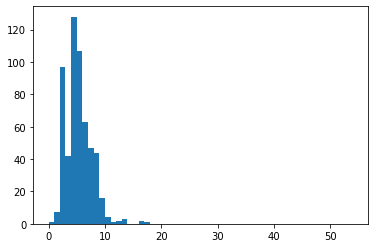

In [56]:
import matplotlib.pyplot as plt
row_hist = plt.hist(n_calificaciones_fila,bins = range(len(df_calificaciones.columns)))
print('Mean of observations per row: ' + str(n_calificaciones_fila.mean()))
n_calificaciones_fila.value_counts(sort = False)

In [60]:
print(len(pd.unique(df_calificaciones['Equipo'])))
print(len(pd.unique(df_calificaciones['Descripción'])))

125
142


In [61]:
df_calificaciones['Descripción'].value_counts()

realizar muestreo-analisis fsco-qco oltc         120
cambiar silica oltc                               76
aplicar sikaflex 1a protecciones mecanic          45
revisar/cambiar motoventilador                    34
hacer seguimiento generacion anormal de gases     20
                                                ... 
cambiar indicador de nivel oltc                    1
cambiar deshumificador fallado oltc                1
aplicar sikaflex protecciones mecanic rv           1
corregir senalizacion rele bucholz r120            1
revisar alarma presente, low level ug1             1
Name: Descripción, Length: 142, dtype: int64